In [ ]:
import numpy as np
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt

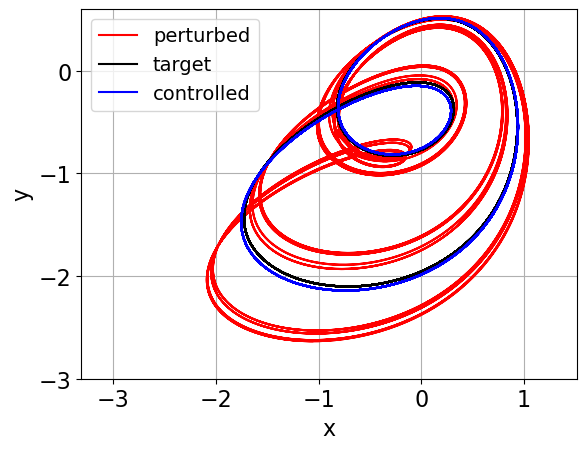

In [ ]:
# %% Parameters

# Model
a_training = 0.340
# a_pert = 0.360;
# a_pert = 0.385;
# a_pert = 0.401;
a_pert = 0.4022
# a_pert = 0.405;
# a_pert = 0.420;
# a_pert = 0.480;

# Time vector
T0 = 1000
T = 500
dt = 0.02
# Note: np.arange is exclusive of the endpoint, add dt to include T if it's a multiple of dt
t = np.arange(0, T + dt, dt)
nt = t.size

tau = 1
alpha = 10

# Noise for training (Currently unused as epsilon is 0)
epsilon = 0*1e-5
noise_x = np.random.randn(nt)
noise_y = np.random.randn(nt)
noise_z = np.random.randn(nt)

# training forcing functions
Ax = 0.1
Ay = 0.1
Az = 0.1

f_x_training = Ax * np.cos((0.1 + 0.1 * np.random.rand()) * t)
f_y_training = Ay * np.sin((0.1 + 0.1 * np.random.rand()) * t)
f_z_training = Az * np.cos((0.1 + 0.1 * np.random.rand()) * t)

# Vector Field (using lambda functions for brevity)
# Note: Use ** for exponentiation in Python
Vx = lambda xf, yf, zf, af: yf + zf
Vy = lambda xf, yf, zf, af: -xf + af * yf
Vz = lambda xf, yf, zf, af: xf**2 - zf

# %% Transient

# Initial condition
x0 = 1.0 * np.random.rand() - 0.5
y0 = 1.0 * np.random.rand() - 0.5
z0 = 1.0 * np.random.rand() - 0.5

nt0 = int(T0 / dt) # Ensure integer number of steps

# Heun's method (RK2) for transient
for i in range(nt0):
    fx = Vx(x0, y0, z0, a_training)
    fy = Vy(x0, y0, z0, a_training)
    fz = Vz(x0, y0, z0, a_training)

    xp = x0 + dt * fx
    yp = y0 + dt * fy
    zp = z0 + dt * fz

    gx = Vx(xp, yp, zp, a_training)
    gy = Vy(xp, yp, zp, a_training)
    gz = Vz(xp, yp, zp, a_training)

    x0 = x0 + (dt / 2) * (fx + gx)
    y0 = y0 + (dt / 2) * (fy + gy)
    z0 = z0 + (dt / 2) * (fz + gz)

# %% Initialize solution vector
# Use 1D arrays of size nt
x_target = np.zeros(nt)
y_target = np.zeros(nt)
z_target = np.zeros(nt)

x_training = np.zeros(nt)
y_training = np.zeros(nt)
z_training = np.zeros(nt)

x_unknown = np.zeros(nt)
y_unknown = np.zeros(nt)
z_unknown = np.zeros(nt)

x_control = np.zeros(nt)
y_control = np.zeros(nt)
z_control = np.zeros(nt)

# %% Target Dynamics

x_target[0] = x0
y_target[0] = y0
z_target[0] = z0

# Loop from 0 to nt-2 to fill indices 1 to nt-1
for i in range(nt - 1):
    fx = Vx(x_target[i], y_target[i], z_target[i], a_training)
    fy = Vy(x_target[i], y_target[i], z_target[i], a_training)
    fz = Vz(x_target[i], y_target[i], z_target[i], a_training)

    xp = x_target[i] + dt * fx
    yp = y_target[i] + dt * fy
    zp = z_target[i] + dt * fz

    gx = Vx(xp, yp, zp, a_training)
    gy = Vy(xp, yp, zp, a_training)
    gz = Vz(xp, yp, zp, a_training)

    x_target[i + 1] = x_target[i] + (dt / 2) * (fx + gx)
    y_target[i + 1] = y_target[i] + (dt / 2) * (fy + gy)
    z_target[i + 1] = z_target[i] + (dt / 2) * (fz + gz)

# %% Reservoir Computing Parameters

# Size of the Reservoir
N = 200

# Dimension of input
D = 3 # (x, y, z input)

# Mean degree of the reservoir
km = 6

# Spectral radius of the reservoir
a_param = 0.95

# Input parameter
b = 0.01

# Ridge Regression Parameter
lambda_ = 1e-8 # Use lambda_ as lambda is a keyword in Python

# Generate random matrices Adjacency matrix for Reservoir
A = np.zeros((N, N))
M = N * km
for _ in range(M): 
    # np.random.randint is exclusive of the high end, so use N for [0, N-1]
    row = np.random.randint(N)
    col = np.random.randint(N)
    # Ensure no self-loops and connection doesn't exist yet
    while A[row, col] != 0 or row == col:
        row = np.random.randint(N)
        col = np.random.randint(N)
    A[row, col] = 2 * np.random.rand() - 1

# Normalize A by its spectral radius (absolute value of largest magnitude eigenvalue)
try:
    eigenvals = eigs(A, k=1, which='LM', return_eigenvectors=False)
    spectral_radius = np.abs(eigenvals[0])
    if spectral_radius == 0:
        print("Warning: Spectral radius is zero. Skipping normalization.")
    else:
        A = A / spectral_radius
except Exception as e:
    print(f"Eigenvalue computation failed: {e}. Matrix A might be ill-conditioned.")
    # Fallback or error handling if needed, here we just proceed without normalization
    pass


# Input matrix B
B = 2 * np.random.rand(N, D) - 1

# %% Reservoir states
# Shape (N, nt)
r_training = np.zeros((N, nt))
# Initial state - random vector of size N
r_training[:, 0] = 2.0 * np.random.rand(N) - 1.0
r_unknown = np.zeros((N, nt))
r_control = np.zeros((N, nt))

# %% Train Reservoir

# Initial condition for training is the end state of target dynamics
x_training[0] = x_target[-1] 
y_training[0] = y_target[-1]
z_training[0] = z_target[-1]

# Heun's method with forcing
for i in range(nt - 1):
    fx = Vx(x_training[i], y_training[i], z_training[i], a_training) + f_x_training[i]
    fy = Vy(x_training[i], y_training[i], z_training[i], a_training) + f_y_training[i]
    fz = Vz(x_training[i], y_training[i], z_training[i], a_training) + f_z_training[i]

    xp = x_training[i] + dt * fx
    yp = y_training[i] + dt * fy
    zp = z_training[i] + dt * fz

    # Need forcing at i+1 for the second step of Heun's method
    gx = Vx(xp, yp, zp, a_training) + f_x_training[i+1]
    gy = Vy(xp, yp, zp, a_training) + f_y_training[i+1]
    gz = Vz(xp, yp, zp, a_training) + f_z_training[i+1]

    x_training[i + 1] = x_training[i] + (dt / 2) * (fx + gx)
    y_training[i + 1] = y_training[i] + (dt / 2) * (fy + gy)
    z_training[i + 1] = z_training[i] + (dt / 2) * (fz + gz)

    # Step reservoir
    # Create the input vector u = [x; y; z] as a column vector (D, 1)
    u_in = np.array([[x_training[i]], [y_training[i]], [z_training[i]]])
    # Use @ for matrix multiplication in Python >= 3.5
    # A is (N, N), r_training[:, i] is (N,), B is (N, D), u_in is (D, 1)
    # Need r_training[:, i] as column vector (N, 1) for A @ r
    # Need B @ u_in results in (N, 1)
    r_col = r_training[:, i].reshape(-1, 1) # Ensure column vector
    r_training[:, i + 1] = np.tanh(a_param * A @ r_col + b * B @ u_in + 1).flatten() # Flatten back to 1D for storage

# %% Find output with ridge regression

# Stack forcing functions vertically: shape (D, nt)
Forcing_target = np.vstack((f_x_training, f_y_training, f_z_training))

# Calculate Wout using the normal equation for ridge regression
# Wout = Y * X' * inv(X * X' + lambda * I)
# Y is Forcing_target (D, nt)
# X is r_training (N, nt)
# X' is r_training.T (nt, N)
# I is identity matrix (N, N)
# Wout should be (D, N)
identity_N = np.eye(N)
# Ensure r_training is treated as the matrix X in the formula Y = W @ X
# Wout @ r_training should approximate Forcing_target
# Wout = Forcing_target @ r_training.T @ np.linalg.inv(r_training @ r_training.T + lambda_ * identity_N) # Original MATLAB version
Wout = Forcing_target @ r_training.T @ np.linalg.inv(r_training @ r_training.T + lambda_ * identity_N)


# Recover the forcing signal using the trained Wout
# Shape (D, N) @ (N, nt) -> (D, nt)
Forcing_training_recovered = Wout @ r_training

f_x_training_recovered = Forcing_training_recovered[0, :]
f_y_training_recovered = Forcing_training_recovered[1, :]
f_z_training_recovered = Forcing_training_recovered[2, :]

# %% Another Transient (using the perturbed parameter a_pert)

# Start from the end of the training phase
x0 = x_training[-1]
y0 = y_training[-1]
z0 = z_training[-1]

# Start reservoir from the last training state
rp = r_training[:, -1].copy() # Use copy to avoid modifying r_training

nt0 = int(T0 / dt) # Number of transient steps

for i in range(nt0):
    # Dynamics with a_pert
    fx = Vx(x0, y0, z0, a_pert)
    fy = Vy(x0, y0, z0, a_pert)
    fz = Vz(x0, y0, z0, a_pert)

    xp = x0 + dt * fx
    yp = y0 + dt * fy
    zp = z0 + dt * fz

    gx = Vx(xp, yp, zp, a_pert)
    gy = Vy(xp, yp, zp, a_pert)
    gz = Vz(xp, yp, zp, a_pert)

    # Step reservoir state forward (without forcing)
    # Input to reservoir is the current state [x0; y0; z0]
    u_in = np.array([[x0], [y0], [z0]])
    rp_col = rp.reshape(-1, 1) # Ensure column vector
    rp = np.tanh(a_param * A @ rp_col + b * B @ u_in + 1).flatten()

    # Update state using Heun's method
    x0 = x0 + (dt / 2) * (fx + gx)
    y0 = y0 + (dt / 2) * (fy + gy)
    z0 = z0 + (dt / 2) * (fz + gz)


# %% Recovery Phase (Run the system with a_pert and record RC state)

# Initialize from the end of the second transient
r_unknown[:, 0] = rp
x_unknown[0] = x0
y_unknown[0] = y0
z_unknown[0] = z0

# Calculate initial predicted forcing and filtered forcing
# Note: up and vp seem to represent predicted and filtered forcing/control signals
# Wout is (D, N), rp is (N,) -> up is (D,)
up = Wout @ rp # Initial predicted forcing
vp = up.copy() # Initial filtered forcing

for i in range(nt - 1):
    # System dynamics with a_pert
    fx = Vx(x_unknown[i], y_unknown[i], z_unknown[i], a_pert)
    fy = Vy(x_unknown[i], y_unknown[i], z_unknown[i], a_pert)
    fz = Vz(x_unknown[i], y_unknown[i], z_unknown[i], a_pert)

    xp = x_unknown[i] + dt * fx
    yp = y_unknown[i] + dt * fy
    zp = z_unknown[i] + dt * fz

    gx = Vx(xp, yp, zp, a_pert)
    gy = Vy(xp, yp, zp, a_pert)
    gz = Vz(xp, yp, zp, a_pert)

    # Update state using Heun's method
    x_unknown[i + 1] = x_unknown[i] + (dt / 2) * (fx + gx)
    y_unknown[i + 1] = y_unknown[i] + (dt / 2) * (fy + gy)
    z_unknown[i + 1] = z_unknown[i] + (dt / 2) * (fz + gz)

    # Calculate predicted forcing from current RC state r_unknown[:, i]
    # Wout is (D, N), r_unknown[:, i] is (N,) -> up is (D,)
    up = Wout @ r_unknown[:, i]
    # Update filtered forcing vp using a simple low-pass filter
    # vp(t+dt) = vp(t) + (dt/tau)*(up(t) - vp(t))
    vp = vp + (dt / tau) * (up - vp)

    # Step reservoir using the *current* system state
    u_in = np.array([[x_unknown[i]], [y_unknown[i]], [z_unknown[i]]])
    r_col = r_unknown[:, i].reshape(-1, 1) # Ensure column vector
    r_unknown[:, i + 1] = np.tanh(a_param * A @ r_col + b * B @ u_in + 1).flatten()


# %% Find output (recovered forcing) during the recovery phase

# Use the RC states from the recovery phase and the trained Wout
# Shape (D, N) @ (N, nt) -> (D, nt)
Forcing_unknown_recovered = Wout @ r_unknown

f_x_unknown_recovered = Forcing_unknown_recovered[0, :]
f_y_unknown_recovered = Forcing_unknown_recovered[1, :]
f_z_unknown_recovered = Forcing_unknown_recovered[2, :]

# %% Control Phase

# Initialize from the end of the recovery phase
r_control[:, 0] = r_unknown[:, -1]
x_control[0] = x_unknown[-1]
y_control[0] = y_unknown[-1]
z_control[0] = z_unknown[-1]

# Initialize control signals u (predicted) and v (filtered/applied)
# Shape (D, nt)
u = np.zeros((D, nt))
v = np.zeros((D, nt))

# Initialize using the last values from the recovery phase
# up and vp were the last predicted and filtered values
u[:, 0] = up # Last predicted control from recovery phase
v[:, 0] = vp # Last filtered control from recovery phase


for i in range(nt - 1):
    # Predict control signal for next step based on *current* RC state
    # u[:, i+1] = Wout @ r_control[:, i] (as in MATLAB code)
    u[:, i+1] = Wout @ r_control[:, i]

    # Update filtered control signal v
    # v(:,i+1) = v(:,i) + (dt/tau)*(u(:,i) - v(:,i)); (as in MATLAB code)
    # Uses u from the *previous* step (u[:, i])
    v[:, i+1] = v[:, i] + (dt / tau) * (u[:, i] - v[:, i])

    # System dynamics with a_pert and control term -alpha*v
    # Control v applied at step i depends on v calculated at the *end* of step i-1 (v[:, i])
    fx = Vx(x_control[i], y_control[i], z_control[i], a_pert) - alpha * v[0, i]
    fy = Vy(x_control[i], y_control[i], z_control[i], a_pert) - alpha * v[1, i]
    fz = Vz(x_control[i], y_control[i], z_control[i], a_pert) - alpha * v[2, i]

    xp = x_control[i] + dt * fx
    yp = y_control[i] + dt * fy
    zp = z_control[i] + dt * fz

    # The control term should be the same for the predictor step gx, gy, gz
    gx = Vx(xp, yp, zp, a_pert) - alpha * v[0, i]
    gy = Vy(xp, yp, zp, a_pert) - alpha * v[1, i]
    gz = Vz(xp, yp, zp, a_pert) - alpha * v[2, i]

    # Update state using Heun's method
    x_control[i + 1] = x_control[i] + (dt / 2) * (fx + gx)
    y_control[i + 1] = y_control[i] + (dt / 2) * (fy + gy)
    z_control[i + 1] = z_control[i] + (dt / 2) * (fz + gz)

    # Step reservoir using the *current* controlled system state
    u_in = np.array([[x_control[i]], [y_control[i]], [z_control[i]]])
    r_col = r_control[:, i].reshape(-1, 1) # Ensure column vector
    r_control[:, i + 1] = np.tanh(a_param * A @ r_col + b * B @ u_in + 1).flatten()

# %% Plotting

# # Figure 1: Training Forcing vs Recovered Forcing
# plt.figure()
# plt.plot(t, f_x_training, 'b-', linewidth=1.5, label='f_x Target')
# plt.plot(t, f_y_training, 'r-', linewidth=1.5, label='f_y Target')
# plt.plot(t, f_z_training, '-', color=[0, 0.5, 0], linewidth=1.5, label='f_z Target') # Green
# plt.plot(t, f_x_training_recovered, 'k--', linewidth=1.5, label='f_x Recovered')
# plt.plot(t, f_y_training_recovered, 'k--', linewidth=1.5, label='f_y Recovered')
# plt.plot(t, f_z_training_recovered, 'k--', linewidth=1.5, label='f_z Recovered')
# plt.grid(True)
# # plt.box(True) # Box is typically on by default
# # plt.axis('square') # Makes axes aspect ratio 1, might not be desired
# # plt.xlim([0, T])
# # plt.ylim([min_val, max_val]) # Adjust ylim if needed
# plt.xlabel('time, t', fontsize=16) # Font name might differ
# plt.ylabel('forcing', fontsize=16)
# plt.legend(fontsize=14, loc='best') # Adjust location if needed
# plt.tick_params(axis='both', which='major', labelsize=16)
# # plt.xticks([...])
# # plt.yticks([...])
# # plt.tick_params(length=...) # For tick length

# # Figure 2: Recovered Forcing during Unknown Phase
# plt.figure()
# plt.plot(t, f_x_unknown_recovered, 'b-', linewidth=1.5, label='f_x Unknown Rec.')
# plt.plot(t, f_y_unknown_recovered, 'r-', linewidth=1.5, label='f_y Unknown Rec.')
# plt.plot(t, f_z_unknown_recovered, '-', color=[0, 0.5, 0], linewidth=1.5, label='f_z Unknown Rec.') # Green
# plt.grid(True)
# # plt.box(True)
# # plt.xlim([0, T])
# # plt.ylim(...) # Adjust ylim if needed
# plt.xlabel('time, t', fontsize=16)
# plt.ylabel('forcing', fontsize=16)
# plt.legend(fontsize=14, loc='best')
# plt.tick_params(axis='both', which='major', labelsize=16)

# # Figure 3: 3D Trajectories (Requires Axes3D)
# # from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# plot_start_index = nt // 2 # Integer division for middle index
# ax.plot(x_unknown[plot_start_index:], y_unknown[plot_start_index:], z_unknown[plot_start_index:], 'r-', linewidth=1.5, label='Perturbed')
# ax.plot(x_target[plot_start_index:], y_target[plot_start_index:], z_target[plot_start_index:], 'k-', linewidth=1.5, label='Target')
# ax.plot(x_control[plot_start_index:], y_control[plot_start_index:], z_control[plot_start_index:], 'b-', linewidth=1.5, label='Controlled')
# ax.grid(True)
# # ax.box(True) # Box is typically on by default in 3D
# ax.set_xlabel('x', fontsize=16)
# ax.set_ylabel('y', fontsize=16)
# ax.set_zlabel('z', fontsize=16)
# ax.legend(fontsize=14, loc='best')
# ax.tick_params(axis='both', which='major', labelsize=16)

# Figure 4: 2D Projection (x-y plane)
plt.figure()
plot_start_index = nt // 2 # Integer division for middle index (equivalent to ceil(nt/2) for indexing start)

plt.plot(x_unknown[plot_start_index:], y_unknown[plot_start_index:], 'r-', linewidth=1.5, label='perturbed')
plt.plot(x_target[plot_start_index:], y_target[plot_start_index:], 'k-', linewidth=1.5, label='target')
plt.plot(x_control[plot_start_index:], y_control[plot_start_index:], 'b-', linewidth=1.5, label='controlled')
# Plotting whole trajectory:
# plt.plot(x_unknown, y_unknown, 'r-', linewidth=1.5, label='perturbed (full)')
# plt.plot(x_target, y_target, 'k-', linewidth=1.5, label='target (full)')
# plt.plot(x_control, y_control, 'b-', linewidth=1.5, label='controlled (full)')

plt.grid(True)
# plt.box(True) # Box on by default
plt.axis('equal') # Make aspect ratio equal
plt.xlim([-2.4, 1.2])
plt.ylim([-2.9, 0.6])
plt.legend(fontsize=14, loc='upper left') # Equivalent to NorthWest
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xticks([-3, -2, -1, 0, 1])
plt.yticks([-3, -2, -1, 0])
# plt.tick_params(length=...) # For tick length adjustment if needed

plt.show()